In [1]:
# import libaries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import collections
from collections import Counter
import bisect
import math
import warnings
import time
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
warnings.filterwarnings('ignore')

sns.set_style("white")

# global variables
DPI = 300
fs = 30

# Read data

In [2]:
data = pd.read_csv("pitch_class_distributions.csv", encoding='utf-8')
data.head()

,year,root,mode,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11
0,1556.0,NaN,NaN,0.062929,0.0,0.268307,0.00000,0.054920,0.100114,0.000000,0.290046,0.0,0.126430,0.097254,0.00000
1,1556.0,NaN,NaN,0.082086,0.0,0.248460,0.00088,0.060739,0.140185,0.000000,0.222711,0.0,0.128521,0.116197,0.00022
2,1556.0,NaN,NaN,0.102664,0.0,0.237204,0.00868,0.058066,0.153996,0.000000,0.172104,0.0,0.137983,0.129303,0.00000
3,1556.0,NaN,NaN,0.088041,0.0,0.242680,0.00000,0.084742,0.122680,0.000825,0.226186,0.0,0.129072,0.105773,0.00000
4,1556.0,NaN,NaN,0.088940,0.0,0.269099,0.00000,0.066135,0.116306,0.000000,0.225770,0.0,0.112885,0.120867,0.00000


In [3]:
data.shape

(13402, 15)

In [4]:
pcs = ["pc"+str(i) for i in range(12)]

In [5]:
print("Number of pieces:")
print(data.shape[0])
print()
print('Number of pieces with key annotation:')
print(data.dropna(subset=['year', 'root', 'mode']).shape[0])

Number of pieces:
13402

Number of pieces with key annotation:
6655


# Split data into periods

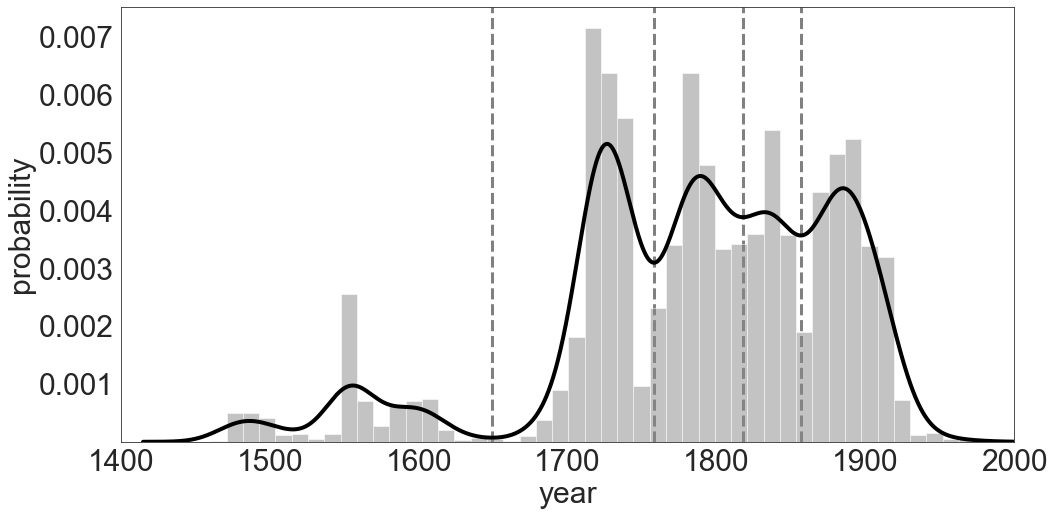

In [6]:
plt.figure(figsize=(16,8))
plt.xlim(1400, 2000)
plt.xticks(fontsize=fs)
plt.yticks([(x+1)*.001 for x in range(7)], fontsize=fs)

lines = sns.distplot(
    data[data["year"] > 1450]["year"], 
    kde_kws={'linewidth':4, 'color':'black', 'gridsize': 100_000}, 
    hist_kws={'alpha':0.5, 'color':'#888888'}
).get_lines()

xs, ys = lines[0].get_data()

mininds = []
a, b = -1, -1
for i,c in enumerate(ys):
    if a > b and b < c:
        mininds.append(i)
    a, b = b, c
_,t1,t2,t3,t4,_ = xs[mininds]

for b in [t1,t2,t3,t4]: 
    plt.axvline(b, c="gray", ls="--", lw=3, zorder=-2)

plt.xlabel("year", fontsize=fs)
plt.ylabel("probability", fontsize=fs)
plt.savefig("img/Figure1.pdf", dpi=DPI)
plt.show()

In [7]:
# add period column to dataframe

data["period"] = (data["year"] < t1) * 0\
    + ((t1 <= data["year"]) & (data["year"] < t2)) * 1\
    + ((t2 <= data["year"]) & (data["year"] < t3)) * 2\
    + ((t3 <= data["year"]) & (data["year"] < t4)) * 3\
    + (t4 <= data["year"]) * 4
period_names = (
    "<" + str(int(t1)), 
    str(int(t1)+1) + "-" + str(int(t2)), 
    str(int(t2)+1) + "-" + str(int(t3)), 
    str(int(t3)+1) + "-" + str(int(t4)), 
    ">" + str(int(t4)+1))
print("periods:")
print(period_names)
print()
print("pieces per period:")
print(data.groupby("period").size())

periods:
('<1649', '1650-1758', '1759-1817', '1818-1856', '>1857')

pieces per period:
period
0    1180
1    3481
2    3311
3    2000
4    3430
dtype: int64


In [8]:
with open("start_years.txt", "w") as text_file:
    text_file.write(str(int(t1)+1) + '\n' + str(int(t2)+1) + '\n' + str(int(t3)+1) + '\n' + str(int(t4)+1))

In [9]:
periods           = range(0, 5)
indices_by_period = [data[data["period"] == p].index for p in periods]
pcwds_by_period   = [data.iloc[inds][pcs].values for inds in indices_by_period]

# ------------------------------------
# RUN JULIA NOTEBOOK HERE
# ------------------------------------

# Calculate distances

In [10]:
# numba compiles python source code to fast machine code
# it is used to speed-ip performance-critical code
from numba import jit

@jit(nopython=True)
def mynorm(v):
    squares = v[0] * v [0]
    for i in range(1, len(v)):
        squares += v[i] * v[i]
    return np.sqrt(squares)


@jit(nopython=True)
def mode_distance(v, w):
    n = len(v)
    minimum = mynorm(v - w)
    
    for i in range(1, n):
        squares = (v[i] - w[0]) * (v[i] - w[0])
        for k in range(1, n):
            squares += (v[(i+k)%n] - w[k]) * (v[(i+k)%n] - w[k])
        norm = np.sqrt(squares)
        if norm < minimum:
            minimum = norm
    return minimum

@jit(nopython=True)
def distance_matrix(X):
    n = X.shape[0]
    M = np.zeros( (n,n) )
    for i in range(n):
        for j in range(i):
            M[i, j] = M[j, i] = mode_distance(X[i,:], X[j,:])
    return M

In [11]:
%%time
distances_by_period = [distance_matrix(pcwds_by_period[p]) for p in periods]

Wall time: 13.3 s


In [12]:
%%time
embeddings = [
    TSNE(metric="precomputed", n_iter=4000, random_state=83146323).fit(distances_by_period[p]).embedding_
    for p in periods
]

Wall time: 5min 36s


In [13]:
# function to adjust the GMM labels to major and minor by hand
# important for the correct coloring in the scatter plot below
def flip_gmm_labels(labels_by_period):
    flip = np.vectorize(lambda b: 0 if b==1 else 1)
        
    return [
        flip(labels_by_period[0]), 
        labels_by_period[1],
        flip(labels_by_period[2]),
        labels_by_period[3],
        flip(labels_by_period[4])
    ]

In [14]:
embdgs = pd.concat(
    [
        pd.DataFrame(
            {
                "x"      : embeddings[p][:,0], 
                "y"      : embeddings[p][:,1], 
                "period" : period_names[p], 
            }
        )
        for p in periods
    ],
    ignore_index = True
)

modes_by_period   = [
    data.iloc[inds]["mode"].replace(np.nan, "unknown").values 
    for inds in indices_by_period
]

labeled_modes = pd.DataFrame(embdgs, copy=True)
labeled_modes["labels"] = "metadata"
labeled_modes["mode"] = np.concatenate(modes_by_period)

GMM_labels_by_period = np.array([
    GaussianMixture(2, covariance_type="full", random_state=42).fit(embeddings[p]).predict(embeddings[p])
    for p in periods
])

flipped_labels_by_period = flip_gmm_labels(GMM_labels_by_period)

gmm_modes = pd.DataFrame(embdgs, copy=True)
gmm_modes["labels"] = "gmm"
gmm_modes["mode"] = np.concatenate([flipped_labels_by_period[p] + 10*p for p in periods])

bayes_modes = pd.DataFrame(embdgs, copy=True)
bayes_modes["labels"] = "bayes"
bayes_modes["mode"] = pd.read_csv("bayesian_predictions.csv")["mode"]

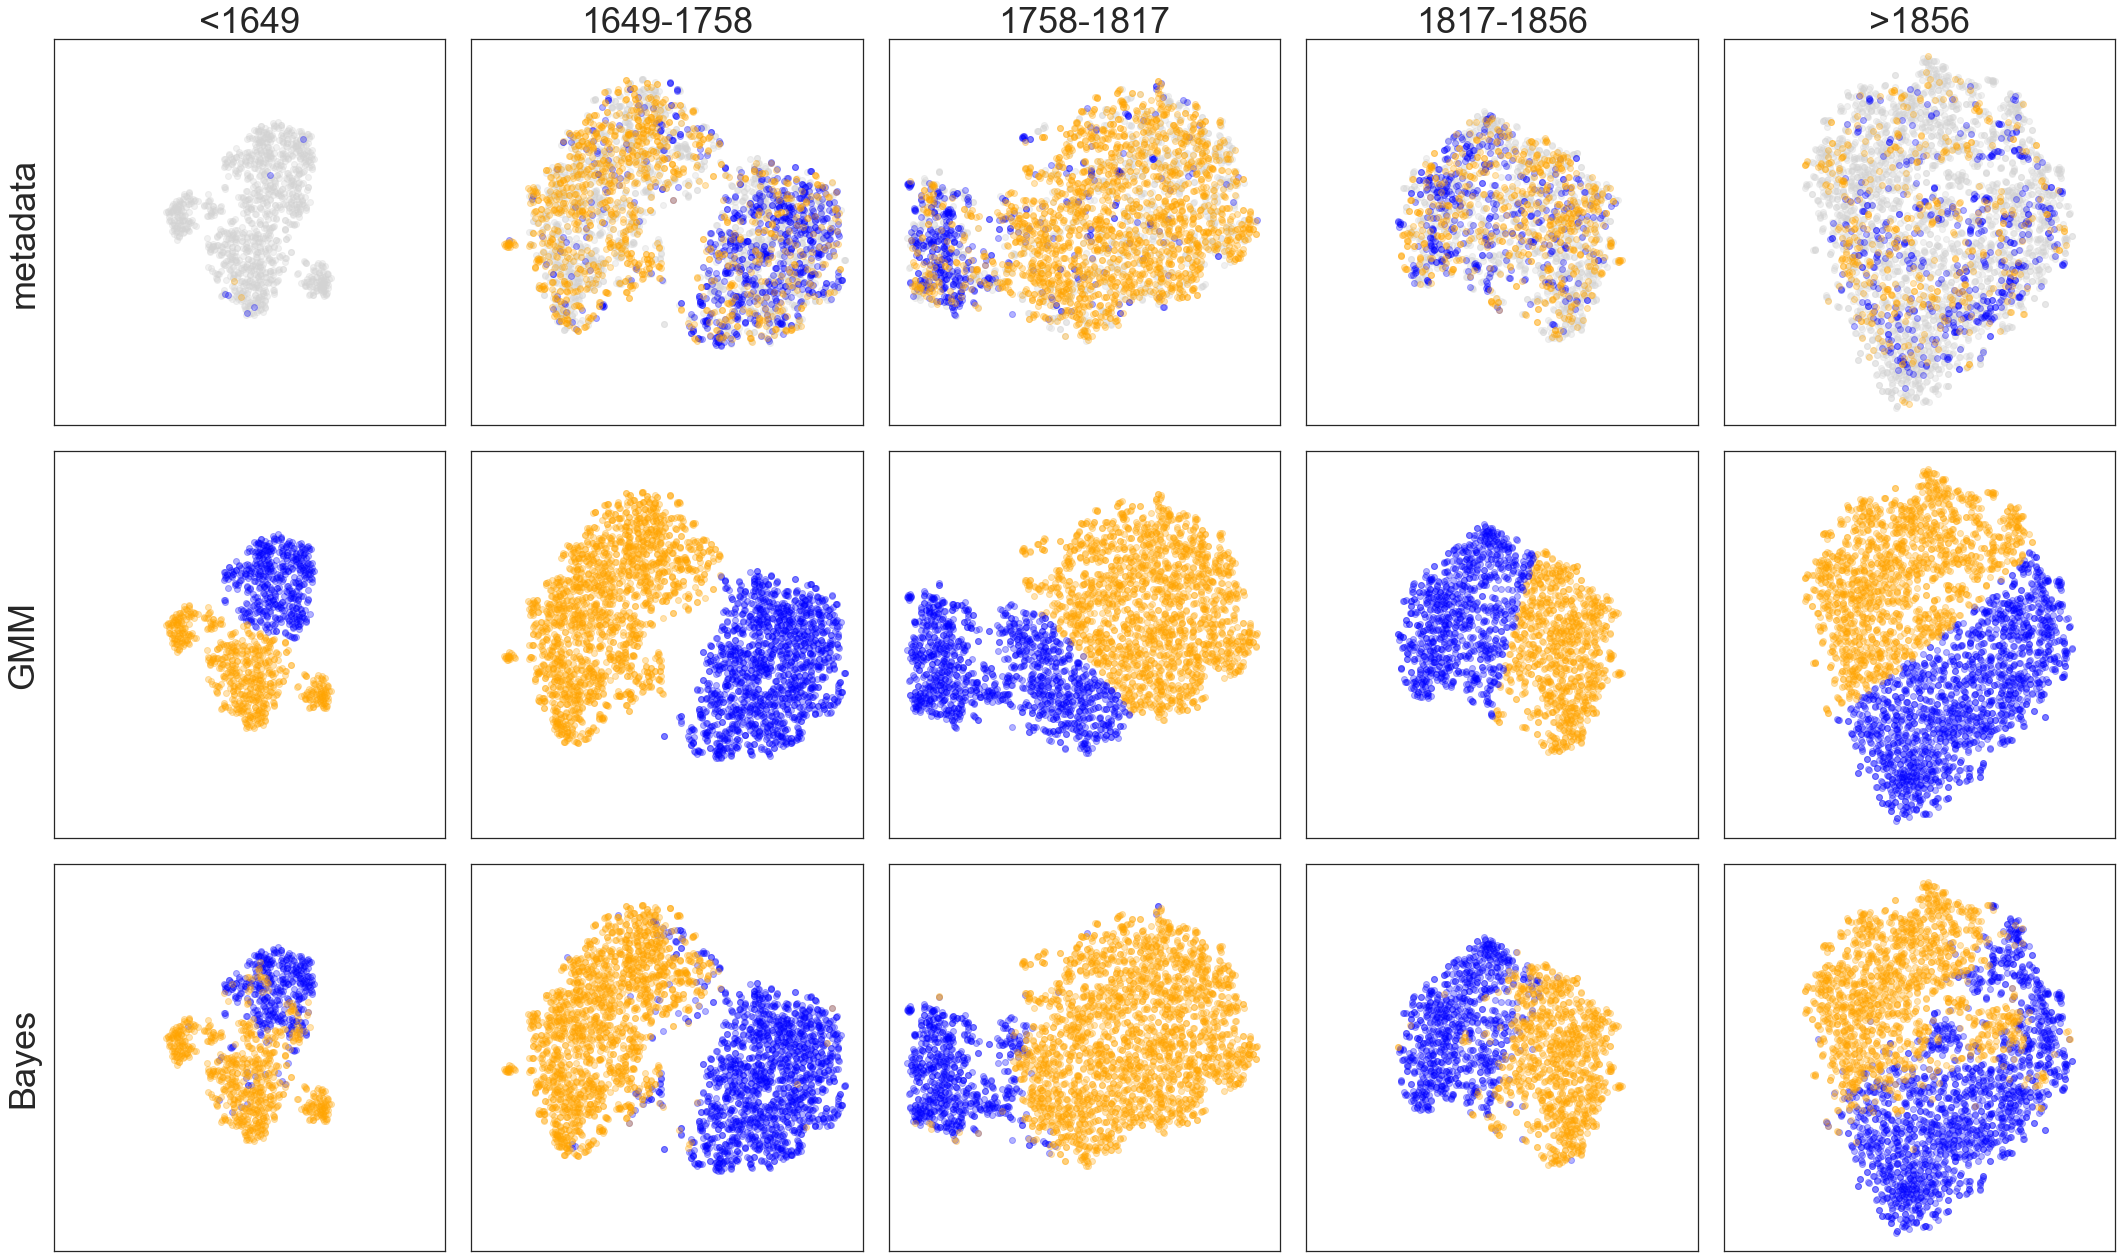

In [18]:
hue_color= {"minor":"blue", "major":"orange", "unknown":"lightgrey", 
            0:"orange", 10:"orange", 20:"blue", 30:"blue", 40:"orange",
            1:"blue", 11:"blue", 21:"orange", 31:"orange", 41:"blue"}

with sns.plotting_context("notebook", font_scale=2):
    g = sns.lmplot(
        data=pd.concat((labeled_modes, gmm_modes, bayes_modes), ignore_index=True), 
        x="x", 
        y="y", 
        col="period", 
        row="labels",
        hue="mode",
        size=6, 
        palette=hue_color, 
        scatter_kws={"alpha":.3}, 
        fit_reg=False,
        legend=False
    )
    
    for ax in g.axes.flatten():
        ax.set(xlabel="", title="")
    
    g.set_xticklabels([])
    g.set_yticklabels([])
    
    g.axes[0,0].set_ylabel(ylabel="metadata", fontsize=36)
    g.axes[1,0].set_ylabel("GMM", fontsize=36)
    g.axes[2,0].set_ylabel("Bayes", fontsize=36)
    
    g.axes[0,0].set_title(f"<{int(t1)}", fontsize=36)
    g.axes[0,1].set_title(f"{int(t1)}-{int(t2)}", fontsize=36)
    g.axes[0,1].set_title(f"{int(t1)}-{int(t2)}", fontsize=36)
    g.axes[0,2].set_title(f"{int(t2)}-{int(t3)}", fontsize=36)
    g.axes[0,3].set_title(f"{int(t3)}-{int(t4)}", fontsize=36)
    g.axes[0,4].set_title(f">{int(t4)}", fontsize=36)
    
    sns.despine(left=False, right=False, bottom=False, top=False)
    
    plt.savefig("img/Figure4.pdf", dpi=DPI)
    plt.tight_layout()
    plt.show()

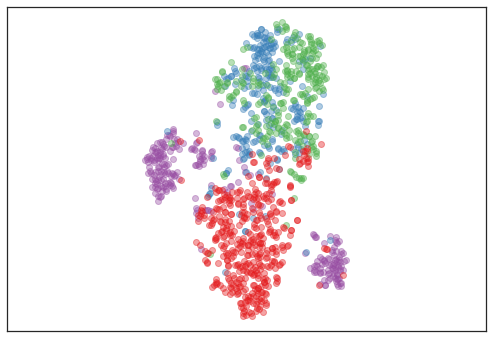

In [19]:
renais_modes = pd.DataFrame(embdgs, copy=True)
renais_modes["labels"] = "bayes"
renais_modes["mode"] = pd.read_csv("renaissance_predictions_4_modes.csv")["mode"]

renais_color = {1:'#984ea3', 2:'#377eb8', 3:'#4daf4a', 4:'#e41a1c', 5:'black'}

with sns.plotting_context("notebook", font_scale=2):
    g = sns.lmplot(
        data=renais_modes,
        x="x", 
        y="y", 
        hue="mode",
        size=6, 
        palette=renais_color, 
        scatter_kws={"alpha":.4}, 
        fit_reg=False,
        sharex=True,
        sharey=True,
        legend=False,
        aspect=1.4
    )
    g.set_xticklabels([])
    g.set_yticklabels([])
    g.set_xlabels("")
    g.set_ylabels("")
    sns.despine(left=False, bottom=False, right=False, top=False)
    
    plt.savefig("img/Figure6.pdf", dpi=DPI, bbox_inches="tight")
    plt.show()

# Silhouette score table

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouetts = pd.DataFrame(
    [
        (period_names[p], k, silhouette_score(
                embeddings[p], 
                GaussianMixture(k, random_state=42, covariance_type="diag").fit(embeddings[p]).predict(embeddings[p])
            ).round(3)
        )
        for p in periods
        for k in range(2,7)
    ],
    columns=["period", "#clusters", "silscore"]
).pivot('#clusters', 'period', 'silscore')[list(period_names)]

silhouetts

period,<1649,1650-1758,1759-1817,1818-1856,>1857
#clusters,,,,,
2,0.430,0.540,0.464,0.421,0.383
3,0.473,0.509,0.398,0.404,0.416
4,0.494,0.456,0.392,0.388,0.406
5,0.430,0.396,0.388,0.366,0.369
6,0.427,0.380,0.381,0.393,0.367


In [21]:
with open("sil_table.txt", "w") as text_file:
    text_file.write(silhouetts.to_latex(index=True))

# Mode Clarity Plot

In [22]:
predictions = pd.concat(
    [
        pd.DataFrame(
            {
                "label" : modes_by_period[p],
                "period" : period_names[p],
                "pc0" : pcwds_by_period[p][:,0],
                "pc1" : pcwds_by_period[p][:,1],
                "pc2" : pcwds_by_period[p][:,2],
                "pc3" : pcwds_by_period[p][:,3],
                "pc4" : pcwds_by_period[p][:,4],
                "pc5" : pcwds_by_period[p][:,5],
                "pc6" : pcwds_by_period[p][:,6],
                "pc7" : pcwds_by_period[p][:,7],
                "pc8" : pcwds_by_period[p][:,8],
                "pc9" : pcwds_by_period[p][:,9],
                "pc10" : pcwds_by_period[p][:,10],
                "pc11" : pcwds_by_period[p][:,11],
            }
        )
        for p in periods
    ],
    ignore_index = True
)

predictions["bayes_mode"] = pd.read_csv("bayesian_predictions.csv")["mode"]
predictions["bayes_root"] = pd.read_csv("bayesian_predictions.csv")["root"]
predictions["correct"] = predictions["label"] == predictions["bayes_mode"]
predictions.head()

,label,period,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,bayes_mode,bayes_root,correct
0,unknown,<1649,0.062929,0.0,0.268307,0.00000,0.054920,0.100114,0.000000,0.290046,0.0,0.126430,0.097254,0.00000,minor,7,False
1,unknown,<1649,0.082086,0.0,0.248460,0.00088,0.060739,0.140185,0.000000,0.222711,0.0,0.128521,0.116197,0.00022,minor,7,False
2,unknown,<1649,0.102664,0.0,0.237204,0.00868,0.058066,0.153996,0.000000,0.172104,0.0,0.137983,0.129303,0.00000,minor,7,False
3,unknown,<1649,0.088041,0.0,0.242680,0.00000,0.084742,0.122680,0.000825,0.226186,0.0,0.129072,0.105773,0.00000,minor,7,False
4,unknown,<1649,0.088940,0.0,0.269099,0.00000,0.066135,0.116306,0.000000,0.225770,0.0,0.112885,0.120867,0.00000,minor,7,False


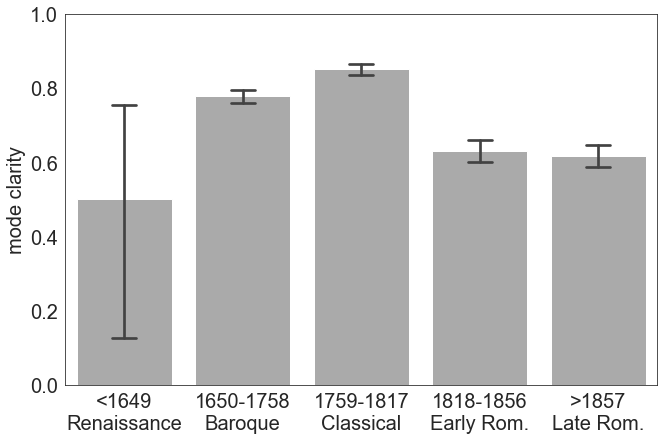

In [23]:
labeled_data = predictions[predictions["label"] != "unknown"]

period_interpretations = ['Renaissance', 'Baroque', 'Classical', 'Early Rom.', 'Late Rom.']

labeled_data.period = labeled_data.period.map(
    { p: p + '\n' + i for (p,i) in zip(list(period_names), period_interpretations) } )

sns.factorplot(
    data=labeled_data, x='period', y='correct', 
    kind='bar', capsize=.2, size=6, aspect=1.5, color='#aaaaaa'
)

sns.despine(left=False, right=False, top=False, bottom=False)
plt.xlim(-0.5, 4.5)
plt.ylim(0, 1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('')
plt.ylabel('mode clarity', fontsize=20)
plt.savefig(os.path.join("img/Figure5.pdf"), dpi=DPI, bbox_inches="tight")
plt.show()

# Violin Plots

In [24]:
renais_preds = pd.read_csv('renaissance_predictions_4_modes.csv')

renaissance_modes = predictions[predictions['period'] == period_names[0]]
renaissance_modes['renais_root'] = renais_preds['root']
renaissance_modes['renais_mode'] = renais_preds['mode']

renaissance_tpcs = np.array(
    [ np.roll(renaissance_modes.loc[i][pcs].values, -renaissance_modes.loc[i]["renais_root"]) 
      for i in renaissance_modes.index ] )

renaissance_wide = pd.concat(
    [
        renaissance_modes,
        pd.DataFrame(
            renaissance_tpcs, 
            columns=[str(i) for i in range(12)], 
            index=renaissance_modes.index )
    ], axis=1 )

renaissance_long = pd.melt(
    renaissance_wide, 
    id_vars="renais_mode", 
    value_vars=[str(i) for i in range(12)], 
    value_name="relative frequency", 
    var_name="pitch class"
)

renaissance_long["relative frequency"] = pd.to_numeric(renaissance_long["relative frequency"])
renaissance_long["pitch class"] = pd.to_numeric(renaissance_long["pitch class"])

renaissance_long.head()

,renais_mode,pitch class,relative frequency
0,2,0,0.290046
1,2,0,0.222711
2,2,0,0.172104
3,2,0,0.226186
4,2,0,0.225770


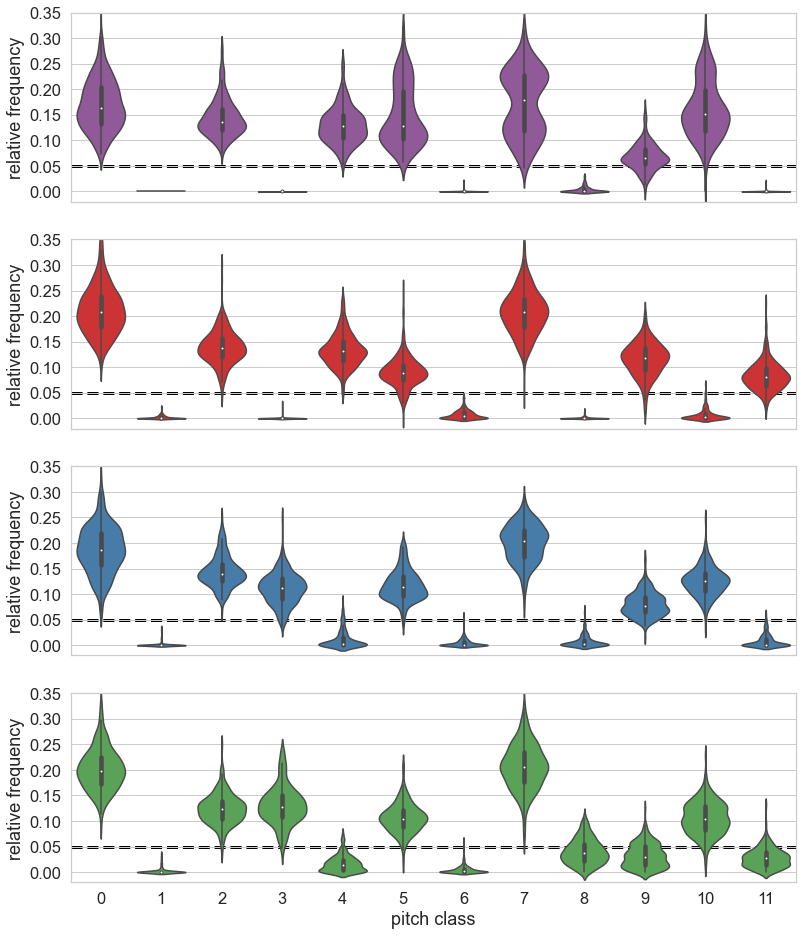

In [26]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(4,1,figsize=(13,16), sharex=True)
    
    for i,k in enumerate([1,4,2,3]): # change this list to change the order of the plots
        axes[i].axhline(y=0.05, color='k', linestyle='dashed', zorder=0, lw=3)
        pc_labels = np.arange(12)
        axes[i].set(ylim=(-.02, .35))
        v = sns.violinplot(
            ax = axes[i],
            x     = 'pitch class', 
            y     = 'relative frequency', 
            data  = renaissance_long[renaissance_long['renais_mode'] == k], 
            # hue   = 'renais_mode', 
            scale = 'width', 
            split = True,
            color = renais_color[k],
            bw    = 0.3, # bandwidth
            inner = 'box'
        )
        v.set_xticklabels(pc_labels)
        v.set_xlabel("")
        v.set_ylabel("relative frequency")
        # v.legend(frameon=True, framealpha=1, edgecolor="black")
        
    v.set_xlabel("pitch class")

plt.savefig("img/Figure7.pdf", dpi=DPI, bbox_inches="tight")
plt.show()

In [27]:
baroque_classical_df = predictions[ 
    (predictions["period"]==period_names[1]) | 
    (predictions["period"]==period_names[2]) ]

baroque_classical_tpcs = np.array(
    [ np.roll(baroque_classical_df.loc[i][pcs].values, -baroque_classical_df.loc[i]["bayes_root"]) 
      for i in baroque_classical_df.index ] )

baroque_classical_wide = pd.concat(
    [
        baroque_classical_df,
        pd.DataFrame(
            baroque_classical_tpcs, 
            columns=[str(i) for i in range(12)], 
            index=baroque_classical_df.index
        )
    ], axis=1 )

baroque_classical_long = pd.melt(
    baroque_classical_wide, 
    id_vars="bayes_mode", 
    value_vars=[str(i) for i in range(12)], 
    value_name="relative frequency", 
    var_name="pitch class"
)

baroque_classical_long["relative frequency"] = pd.to_numeric(baroque_classical_long["relative frequency"])
baroque_classical_long["pitch class"] = pd.to_numeric(baroque_classical_long["pitch class"])

baroque_classical_long.head()

,bayes_mode,pitch class,relative frequency
0,minor,0,0.185200
1,major,0,0.207800
2,minor,0,0.175280
3,major,0,0.290656
4,major,0,0.137614


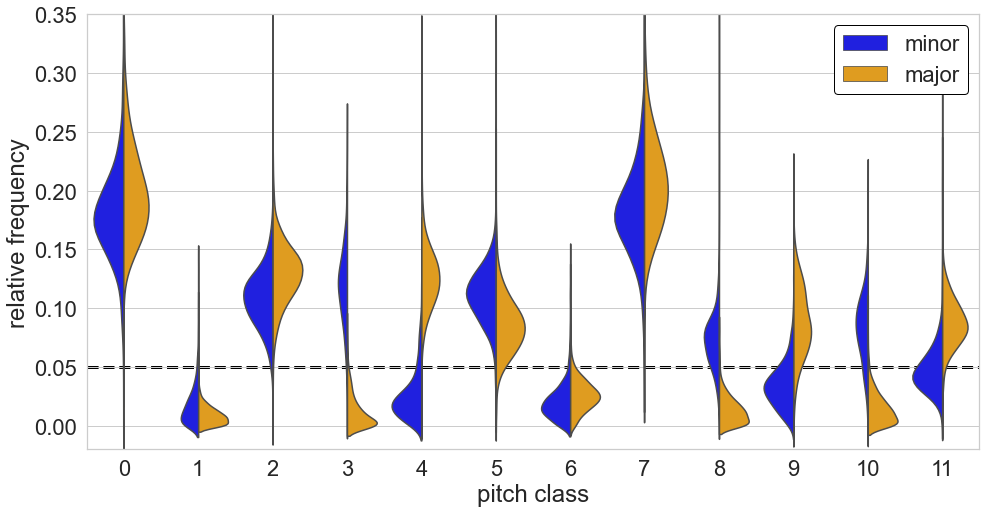

In [28]:
with sns.plotting_context("notebook", font_scale=2):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(16,8))
    ax.axhline(y=0.05, color='k', linestyle='dashed', zorder=0, lw=3)
    pc_labels = np.arange(12)
    ax.set(ylim=(-.02, .35))
    v = sns.violinplot(
        x     = 'pitch class', 
        y     = 'relative frequency', 
        data  = baroque_classical_long, 
        hue   = 'bayes_mode', 
        scale = 'area', 
        split = True,
        palette = hue_color,
        bw    = 0.3, # bandwidth
        inner = None
    )
    v.set_xticklabels(pc_labels)
    v.set_xlabel("pitch class")
    v.set_ylabel("relative frequency")
    v.legend(frameon=True, framealpha=1, edgecolor="black")
    
plt.savefig("img/Figure8.pdf", dpi=DPI, bbox_inches="tight")
plt.show()

# Radar plots

In [29]:
templates = pd.read_csv('templates.csv')
templates['source'] = templates['source'].map(lambda s: s.title())
templates

,source,mode,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11
0,Metadata,major,0.167282,0.025889,0.117140,0.035650,0.111231,0.090045,0.038266,0.167520,0.034084,0.092727,0.039501,0.080666
1,Metadata,minor,0.155646,0.034628,0.099032,0.104433,0.048477,0.103971,0.034020,0.155154,0.074568,0.053348,0.083074,0.053649
2,Bayes,major,0.199861,0.008951,0.130082,0.012229,0.126477,0.085441,0.026322,0.206465,0.013284,0.088423,0.014491,0.087974
3,Bayes,minor,0.179562,0.016820,0.108441,0.119238,0.025517,0.111965,0.020109,0.181843,0.072037,0.034343,0.082553,0.047571
4,Krumhansl,major,0.151950,0.053362,0.083274,0.055755,0.104810,0.097870,0.060302,0.124192,0.057191,0.087581,0.054798,0.068916
5,Krumhansl,minor,0.142215,0.060211,0.079083,0.120872,0.058414,0.079308,0.057066,0.106718,0.089418,0.060436,0.075039,0.071220
6,Temperley,major,0.129870,0.051948,0.090909,0.051948,0.116883,0.103896,0.051948,0.116883,0.051948,0.090909,0.038961,0.103896
7,Temperley,minor,0.129870,0.051948,0.090909,0.116883,0.051948,0.103896,0.051948,0.116883,0.090909,0.051948,0.038961,0.103896
8,Albrecht,major,0.238000,0.006000,0.111000,0.006000,0.137000,0.094000,0.016000,0.214000,0.009000,0.080000,0.008000,0.081000
9,Albrecht,minor,0.220441,0.006012,0.104208,0.123246,0.019038,0.103206,0.012024,0.214429,0.062124,0.022044,0.061122,0.052104


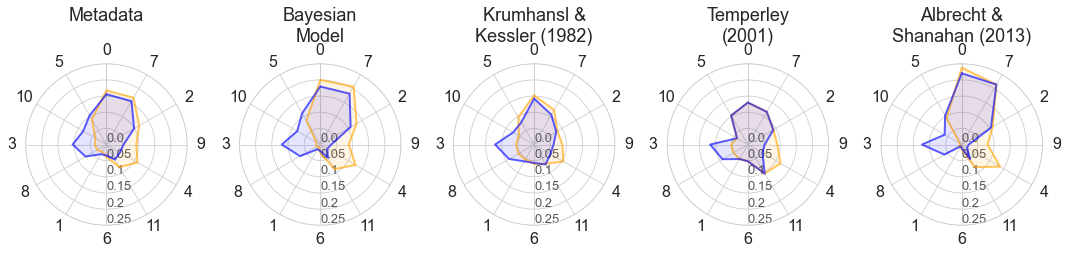

In [30]:
from math import pi

fifhts_order = [k*7 % 12 for k in range(12)]
title_size = 18
label_size = 16
area_alpha = 0.1
line_alpha = 0.6

# angle of each axis
angles = [n / float(12) * 2 * pi for n in range(12)]
# add first angle in order to close the circle
angles += angles[:1] 

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 8), subplot_kw={'polar':True})

fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=1)

# set column titles
cols = ['{}'.format(col) for col in templates['source'].unique()]
cols = ['Metadata\n ', 'Bayesian\nModel', 'Krumhansl &\nKessler (1982)', 'Temperley\n(2001)', 'Albrecht &\nShanahan (2013)']
for ax, col in zip(axes, cols):
    ax.set_title(col)

modes  = ["major", "minor"]
colors = ['orange', 'blue']

for i, ax in enumerate(axes):
    # initialize radar plot
    ax.set_theta_offset(pi / 2) # Put first axis on top
    ax.set_theta_direction(-1) # clockwise

    # Draw angles for pitch classes
    ax.set_xticks(angles)

    # set position in degrees (360°) and labels for values
    ax.set_rlabel_position(0)
    # rlabels = np.linspace(0,0.25, 6, endpoint=True)
    rlabels = [0.00, 0.05, 0.10, 0.15, 0.2, 0.25]
    ax.set_rticks([l for l in rlabels])
    ax.set_rlabel_position(180)
    ax.set_yticklabels(rlabels, fontdict={'fontsize':13, 'color':'#555555'})

    # cut off y-axis
    ax.set_ylim(0, .25) 

    # format title
    ax.title.set_fontsize(title_size)
    ax.title.set_position([.5, 1.1])
    
    for m in range(2):
        values = templates.iloc[2*i+m][["pc" + str(k) for k in fifhts_order]]
        values = np.append(values, values[0])
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=modes[m], alpha=line_alpha, color=colors[m])
        ax.fill(angles, values, color=colors[m], alpha=area_alpha)
        ax.set_xticklabels(fifhts_order, fontdict={'fontsize':label_size})

fig.tight_layout()

plt.savefig("img/Figure9.pdf", dpi=DPI, bbox_inches="tight")

plt.show()